<h2>Fashion MNIST Image Classification</h2>
<h3>ST1504 Deep Learning CA1 Part A</h3>

<h4><b>References:</b></h4>
&#8226; Random Erasing Data Augmentation: https://arxiv.org/pdf/1708.04896.pdf <br>
&#8226; Wide Residual Networks: https://arxiv.org/pdf/1605.07146.pdf

<h4><b>Notebook Contents:</b></h4>
1. Data Exploration/Background Research<br>
2. Data Augmentation/Feature Engineering<br>
3. Modelling & Evaluation<br>
4. Model Improvement<br>

<h3><b>1. Data Exploration/ Background Research</b></h3>

The Fashion MNIST Dataset is a dataset of Zalando's images, with 60000 examples for training and 10000 examples for testing. Each example is a 28x28 greyscale image, with 10 associated labels.

In [2]:
%load_ext tensorboard
import tensorflow as tf
import keras
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
import pandas as pd
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from keras import backend as K
from keras.layers import LSTM,ReLU, Dense,GaussianNoise, Bidirectional, Conv2D, AveragePooling2D, GlobalAveragePooling2D,MaxPooling2D, BatchNormalization, Dropout
(image_train,labels_train),(image_test,labels_test)= tf.keras.datasets.fashion_mnist.load_data()
image_train, image_val,labels_train,labels_val = train_test_split(image_train,labels_train,test_size=0.1, shuffle=False)
image_test = image_test/255
image_val = image_val/255
image_train2 = image_train/255

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


* Import all modules
* Load dataset
* Rescale test and train images

In [3]:
print(image_train.shape)
print(labels_train.shape)
print(image_val.shape)
print(labels_val.shape)
print(image_test.shape)
print(labels_test.shape)

(54000, 28, 28)
(54000,)
(6000, 28, 28)
(6000,)
(10000, 28, 28)
(10000,)


* 54000 images of 28 pixels by 28 pixels for training and 54000 labels to pair with the images

* 6000 images of 28 x 28 for validation and 6000 labels

* 10000 images of 28 pixels by 28 pixels for testing and 10000 labels to pair with the images

In [5]:
class_names =['T-shirt/top', 'Trouser', 'Pullover', 
'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

* One hot encode to do label smoothing
* Label smoothing can help our model make less overconfident predictions

In [3]:
labels_train_oh = to_categorical(labels_train,len(class_names))
labels_val_oh = to_categorical(labels_val,len(class_names))
labels_test_oh = to_categorical(labels_test,len(class_names))
epsilon = 0.001
labels_train_oh = labels_train_oh * (1 - epsilon) + epsilon / 10

* Load label names

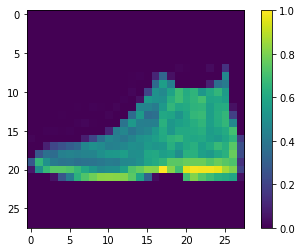

In [7]:
plt.figure()
plt.imshow(image_test[0])
plt.colorbar()
plt.grid(False)
plt.show()

* 28x28 image loaded

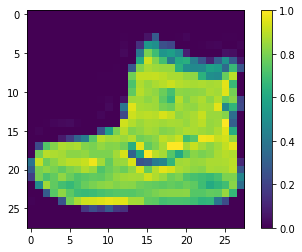

In [11]:
plt.figure()
plt.imshow(image_train2[0])
plt.colorbar()
plt.grid(False)
plt.show()

* 28x28 image rescaled

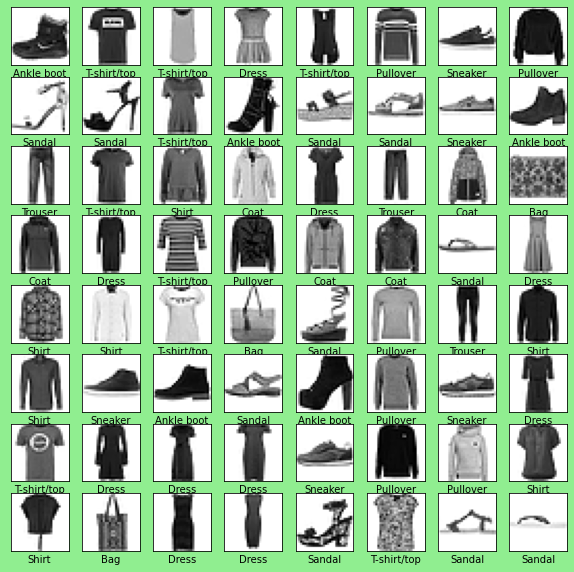

In [6]:
plt.figure(figsize=(10,10),facecolor="lightgreen")
for i in range(64): # 64 imgs
  plt.subplot(8,8,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image_train[i], cmap=plt.cm.binary) # printing binary/black and white image
  plt.xlabel(class_names[labels_train[i]])
plt.show()

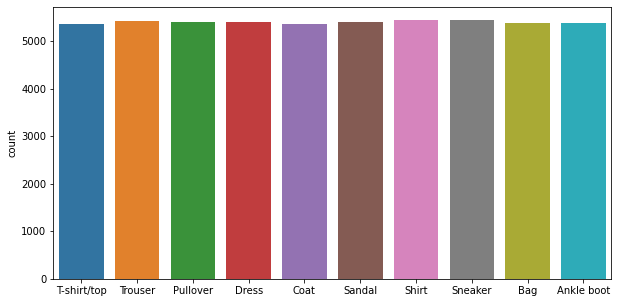

In [20]:
plt.figure(figsize=(10,5))
ax = sns.countplot(x = labels_train)
ax.set_xticklabels(class_names)
plt.show()

* Trainings images for each class are similar in number, no skewed training should occur
* Dataset is balanced

<h2>Objectives/Tasks</h2>

* Be able to accurately identify the test images fed to the model
* Get highest possible accuracy and loss (>95% accuracy)
* Use regularization methods, data augmentation and different model architecture to reduce overfitting while improving accuracy and loss

<h3><b>2. Data Augmentation</h3></b>

* Defined function to execute random erasing on training images

In [4]:
import random
import math
def RandomErasing(img,probability=0.5,sl=0.02,sh=0.4,r1=0.3):
    
    if random.uniform(0, 1) > probability:
        return img/255
    for attempt in range(100):
        area = img.shape[1] * img.shape[0]
       
        target_area = random.uniform(sl, sh) * area
        aspect_ratio = random.uniform(r1, 1/r1)

        h = int(round(math.sqrt(target_area * aspect_ratio)))
        w = int(round(math.sqrt(target_area / aspect_ratio)))

        
        if w < img.shape[1] and h < img.shape[0]:
            x1 = random.randint(0, img.shape[1] - h)
            y1 = random.randint(0, img.shape[0] - w)
            erase_area = tf.cast(tf.random.uniform([h, w, img.shape[2]], 0, 255, tf.int32), tf.uint8)
            img[x1:x1+h, y1:y1+w,:] = erase_area
                
            return img/255


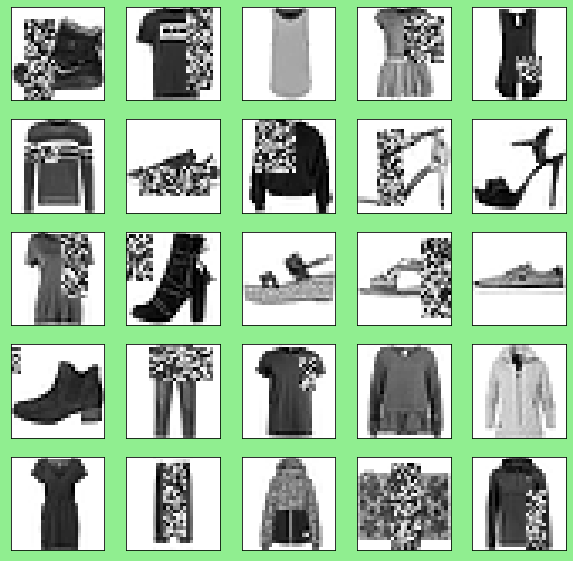

In [201]:
#show examples of random erasing
plt.figure(figsize=(10,10),facecolor="lightgreen")
new = image_train[0:25]
new = np.expand_dims(new,-1)
check = []
for i in new:
    check.append(RandomErasing(i,0.5,0.02,0.3,0.3))
for i in range(25): #25img
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(check[i], cmap=plt.cm.binary) # printing binary/black and white image
plt.show()

* Random Erasing
* Erases a rectangular region of the image and replaces with random values

<h3><b>3. Modelling & Evaluation</h3></b>

<h3>Metrics Used</h3>

* Top 1 accuracy
* Top 3 accuracy
* Loss

* Defined function for creating Wide ResNet model

In [5]:
def residual_block(x, in_nb_filters=16, nb_filters=16, stride=1, drop_prob=0.3):
    strides = (stride, stride)
    if in_nb_filters != nb_filters:
        x = BatchNormalization()(x)
        x = ReLU()(x)
    else:
        new = BatchNormalization()(x)
        new = ReLU()(new)
    new = Conv2D(nb_filters, (3, 3), strides=strides, padding='same')(new if in_nb_filters == nb_filters else x)
    new = BatchNormalization()(new)
    new = ReLU()(new)
    new = Dropout(rate=drop_prob)(new)
    new = Conv2D(nb_filters, (3, 3), strides=(1, 1), padding='same')(new)
    shortcut = Conv2D(nb_filters,(1,1),strides=strides)(x)
    return tf.keras.layers.Add()([x if in_nb_filters == nb_filters else shortcut,new])


def WRN(x, params):

    depth = params['depth']
    width = params['width']
    drop_prob = params['drop_prob']
    assert (depth - 4) % 6 == 0
    num_residual_units = (depth - 4) // 6
    nb_filters = [x * width for x in [16, 32, 64]]

    x = tf.keras.layers.Conv2D(16, 3, strides=(1, 1), padding='same', name='conv')(x)
    in_nb_filters = 16
    for i in range(0, num_residual_units):

            x = residual_block(x,
                               in_nb_filters=in_nb_filters,
                               nb_filters=nb_filters[0],
                               stride=1,
                               drop_prob=drop_prob)
            in_nb_filters = nb_filters[0]
    for i in range(0, num_residual_units):
        if i == 0:
            stride = 2
        else:
            stride = 1
        x = residual_block(x,
                               in_nb_filters=in_nb_filters,
                               nb_filters=nb_filters[1],
                               stride=stride,
                               drop_prob=drop_prob)
        in_nb_filters = nb_filters[1]
    for i in range(0, num_residual_units):
        if i == 0:
            stride = 2
        else:
            stride = 1
        x = residual_block(x,
                               in_nb_filters=in_nb_filters,
                               nb_filters=nb_filters[2],
                               stride=stride,
                               drop_prob=drop_prob)
        in_nb_filters = nb_filters[2]
    x = BatchNormalization(name='bn_out')(x)
    x = ReLU(name='relu_last')(x)
    x = AveragePooling2D((7,7))(x)
    x = tf.keras.layers.Flatten()(x)
    x = Dense(params['num_classes'], name='fc',activation='softmax')(x)
    return x

* ResNet architechture, bottleneck residual block
* Wide ResNet architechture makes bottleneck residual block wider while maintaining depth, increase in width
* Able to dynamically tweak depth and width to suit task

<h4>Basic Baseline</h4>

In [22]:
input = tf.keras.Input((28,28,1))
x = Conv2D(32,(3,3),(1,1),'same')(input)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Conv2D(32,(3,3),(1,1),'same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPooling2D()(x)
x = Conv2D(64,(3,3),(2,2),'same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Conv2D(64,(3,3),(1,1),'same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPooling2D()(x)
x = Conv2D(128,(3,3),(1,1),'same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Conv2D(128,(3,3),(1,1),'same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = GlobalAveragePooling2D()(x)
x = Dense(10,'softmax')(x)
opt = tf.keras.optimizers.SGD(momentum=0.9,decay=0.0005,nesterov=True)
def scheduler(epoch,lr):
    if epoch <5:
        lr = 0.1
        print('Learning rate:',lr)
        return lr
    elif epoch < 25:
        lr = 0.01
        print('Learning rate:',lr)
        return lr
    else:
        lr = 0.001
        print('Learning rate:',lr)
        return lr
baseline = keras.models.Model(inputs=input,outputs = x)
top3 = tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3,name='top_3_accuracy')
baseline.compile(optimizer=opt,loss='sparse_categorical_crossentropy',metrics=['accuracy',top3])
checkpoint = tf.keras.callbacks.ModelCheckpoint('tmp/checkpoint/baselineA.hdf5',verbose=True)
getAcc = tf.keras.callbacks.ModelCheckpoint('tmp/checkpoint/baselineA_Acc.hdf5',verbose=True,save_best_only=True,monitor='val_accuracy')
getLoss = tf.keras.callbacks.ModelCheckpoint('tmp/checkpoint/baselineA_Loss.hdf5',verbose=True,save_best_only=True,monitor='val_loss')
scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

* Simple CNN with few Conv2D layers, BatchNorm and ReLU after every Conv2D, add some MaxPooling and a GlobalAveragePolling at the end, end with Dense softmax
* SGD optimizer with decay, Nesterov momentum, reduce learning rate after epoch 5 to 0.01 and to 0.001 after 25

In [ ]:
baseline_history = baseline.fit(image_train2,labels_train,batch_size=128,epochs=50,validation_data=(image_val,labels_val),callbacks=[checkpoint,scheduler,getAcc,getLoss])

In [24]:
baseline.load_weights('tmp/checkpoint/baselineA_Acc.hdf5')
scoreAcc = baseline.evaluate(image_test,labels_test)
baseline.load_weights('tmp/checkpoint/baselineA_Loss.hdf5')
scoreLoss = baseline.evaluate(image_test,labels_test)
print('Best Acc Test Loss:', scoreAcc[0])
print('Best Acc Test Accuracy:', round(scoreAcc[1],4)*100,'%')
print('Best Loss Test Loss:', scoreLoss[0])
print('Best Loss Test Accuracy:', round(scoreLoss[1],4)*100,'%')

313/313 [==============================] - 1s 3ms/step - loss: 0.2032 - accuracy: 0.9292 - top_3_accuracy: 0.9941
Best Acc Test Loss: 0.20688362419605255
Best Acc Test Accuracy: 93.06 %
Best Loss Test Loss: 0.20324310660362244
Best Loss Test Accuracy: 92.92 %


* Simple model achieves extremely high accuracy
* Simplicity of dataset allows for that
* 10 class dataset with only greyscale images

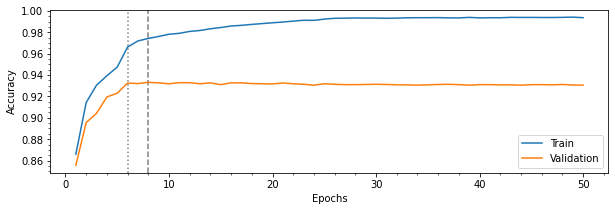

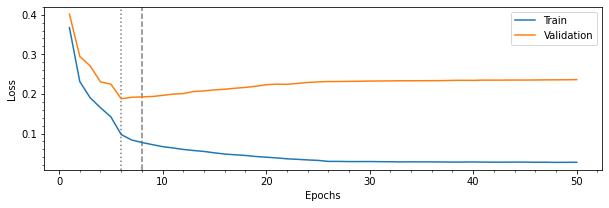

In [28]:
max_val_acc_epoch = np.argmax(list(baseline_history.history['val_accuracy']))+1
max_val_loss_epoch = np.argmin(list(baseline_history.history['val_loss']))+1
epochs = range(1, len(baseline_history.history['accuracy']) + 1)
plt.figure(figsize=(10,3))
plt.minorticks_on()
plt.axvline(x=max_val_acc_epoch, color='0.5', linestyle='--')
plt.axvline(x=max_val_loss_epoch, color='0.5', linestyle=':')
plt.plot(epochs,baseline_history.history['accuracy'], label='Train')
plt.plot(epochs,baseline_history.history['val_accuracy'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10,3))
plt.minorticks_on()
plt.axvline(x=max_val_acc_epoch, color='0.5', linestyle='--')
plt.axvline(x=max_val_loss_epoch, color='0.5', linestyle=':')
plt.plot(epochs,baseline_history.history['loss'], label='Train')
plt.plot(epochs,baseline_history.history['val_loss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

* Overfitting can be observed

<h3><b>4. Model Improvement</h3></b>

<h4>WRN 22-10 vs WRN 28-10 vs WRN 40-10</h4>

* Used WideResNet architecture to write CNN model with increased depth and width from baseline model
* Did comparisons on different depths, set width to 10
* Implemented regularization methods like Batch Normalization and Dropout

In [15]:
params22_10 = {'depth': 22,
          'width': 10,
          'drop_prob': 0.3,
          'num_classes': 10}
params28_10 = {'depth': 28,
          'width': 10,
          'drop_prob': 0.3,
          'num_classes': 10}
params40_10 = {'depth': 40,
          'width': 10,
          'drop_prob': 0.3,
          'num_classes': 10}
x = tf.keras.Input((28,28,1))
opt = tf.keras.optimizers.SGD(momentum=0.9,decay=0.0005,nesterov=True,learning_rate=0.1)
top3 = tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3,name='top_3_accuracy')

In [4]:
out22_10 = WRN(x,params22_10)
wrn22_10 = keras.models.Model(inputs=x,outputs = out22_10)
wrn22_10.compile(optimizer=opt,loss='sparse_categorical_crossentropy',metrics=['accuracy',top3])
wrn22_10.fit(image_train2,labels_train,batch_size=128,epochs=5,validation_data=(image_val,labels_val),verbose=1)

Epoch 1/5
422/422 [==============================] - 134s 301ms/step - loss: 0.4862 - accuracy: 0.8207 - top_3_accuracy: 0.9714 - val_loss: 1.6808 - val_accuracy: 0.6018 - val_top_3_accuracy: 0.7643
Epoch 2/5
422/422 [==============================] - 125s 296ms/step - loss: 0.2699 - accuracy: 0.9015 - top_3_accuracy: 0.9922 - val_loss: 0.2895 - val_accuracy: 0.8963 - val_top_3_accuracy: 0.9920
Epoch 3/5
422/422 [==============================] - 125s 297ms/step - loss: 0.2230 - accuracy: 0.9193 - top_3_accuracy: 0.9945 - val_loss: 0.2710 - val_accuracy: 0.9048 - val_top_3_accuracy: 0.9922
Epoch 4/5
422/422 [==============================] - 126s 298ms/step - loss: 0.1937 - accuracy: 0.9302 - top_3_accuracy: 0.9958 - val_loss: 0.2284 - val_accuracy: 0.9223 - val_top_3_accuracy: 0.9950
Epoch 5/5
422/422 [==============================] - 126s 298ms/step - loss: 0.1728 - accuracy: 0.9367 - top_3_accuracy: 0.9971 - val_loss: 0.2022 - val_accuracy: 0.9285 - val_top_3_accuracy: 0.9937


In [5]:
out28_10 = WRN(x,params28_10)
wrn28_10 = keras.models.Model(inputs=x,outputs = out28_10)
wrn28_10.compile(optimizer=opt,loss='sparse_categorical_crossentropy',metrics=['accuracy',top3])
wrn28_10.fit(image_train2,labels_train,batch_size=128,epochs=5,validation_data=(image_val,labels_val),verbose=1)

Epoch 1/5
422/422 [==============================] - 172s 392ms/step - loss: 0.5517 - accuracy: 0.7974 - top_3_accuracy: 0.9645 - val_loss: 0.5557 - val_accuracy: 0.8213 - val_top_3_accuracy: 0.9722
Epoch 2/5
422/422 [==============================] - 164s 390ms/step - loss: 0.2822 - accuracy: 0.8964 - top_3_accuracy: 0.9915 - val_loss: 0.2960 - val_accuracy: 0.8890 - val_top_3_accuracy: 0.9930
Epoch 3/5
422/422 [==============================] - 165s 391ms/step - loss: 0.2306 - accuracy: 0.9173 - top_3_accuracy: 0.9941 - val_loss: 0.2189 - val_accuracy: 0.9227 - val_top_3_accuracy: 0.9945
Epoch 4/5
422/422 [==============================] - 165s 390ms/step - loss: 0.2005 - accuracy: 0.9267 - top_3_accuracy: 0.9955 - val_loss: 0.2051 - val_accuracy: 0.9272 - val_top_3_accuracy: 0.9943
Epoch 5/5
422/422 [==============================] - 165s 390ms/step - loss: 0.1777 - accuracy: 0.9353 - top_3_accuracy: 0.9968 - val_loss: 0.2607 - val_accuracy: 0.9115 - val_top_3_accuracy: 0.9943


In [5]:
out40_10 = WRN(x,params40_10)
wrn40_10 = keras.models.Model(inputs=x,outputs = out40_10)
wrn40_10.compile(optimizer=opt,loss='sparse_categorical_crossentropy',metrics=['accuracy',top3])
test = wrn40_10.fit(image_train2,labels_train,batch_size=64,epochs=5,validation_data=(image_val,labels_val),verbose=1)

Epoch 1/5
844/844 [==============================] - 281s 324ms/step - loss: 0.5175 - accuracy: 0.8107 - top_3_accuracy: 0.9723 - val_loss: 0.4800 - val_accuracy: 0.8265 - val_top_3_accuracy: 0.9822
Epoch 2/5
844/844 [==============================] - 273s 324ms/step - loss: 0.2951 - accuracy: 0.8911 - top_3_accuracy: 0.9915 - val_loss: 0.2709 - val_accuracy: 0.9013 - val_top_3_accuracy: 0.9912
Epoch 3/5
844/844 [==============================] - 274s 324ms/step - loss: 0.2410 - accuracy: 0.9116 - top_3_accuracy: 0.9942 - val_loss: 0.2358 - val_accuracy: 0.9130 - val_top_3_accuracy: 0.9935
Epoch 4/5
844/844 [==============================] - 274s 324ms/step - loss: 0.2100 - accuracy: 0.9231 - top_3_accuracy: 0.9951 - val_loss: 0.2170 - val_accuracy: 0.9217 - val_top_3_accuracy: 0.9930
Epoch 5/5
844/844 [==============================] - 273s 324ms/step - loss: 0.1898 - accuracy: 0.9304 - top_3_accuracy: 0.9965 - val_loss: 0.2024 - val_accuracy: 0.9265 - val_top_3_accuracy: 0.9950


* WRN chosen is depth 28, width 10
* Create model WRN28-10
* Optimizer as SGD, initial learning rate = 0.1
* Epochs = 300, after epoch 150, learning rate = 0.01, after epoch 225, learning rate = 0.001
* Validation set of 10% of training data (6000 images for validation)
* Fit model and evaluate loading with best validation accuracy and loss
* Plot history graph to see progress of loss and accuracy

In [19]:
top3 = tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3,name='top_3_accuracy')
def scheduler(epoch,lr):
    if epoch <150:
        lr = 0.1
        print('Learning rate:',lr)
        return lr
    elif epoch < 225:
        lr = 0.01
        print('Learning rate:',lr)
        return lr
    else:
        lr = 0.001
        print('Learning rate:',lr)
        return lr

params = {'depth': 28,
          'width': 10,
          'drop_prob': 0.3,
          'num_classes': 10}
x = tf.keras.Input((28,28,1))
out = WRN(x,params)
log_28_10 = CSVLogger('tmp/WRN28_10.csv',separator = ',',append=True)
model = keras.models.Model(inputs=x,outputs = out)
opt = tf.keras.optimizers.SGD(momentum=0.9,decay=0.0005,nesterov=True,learning_rate=0.1)
checkpoint = tf.keras.callbacks.ModelCheckpoint('tmp/checkpoint/WRN_28-10.hdf5',verbose=True)
getAcc = tf.keras.callbacks.ModelCheckpoint('tmp/checkpoint/WRN_28-10_Acc.hdf5',verbose=True,save_best_only=True,monitor='val_accuracy')
getLoss = tf.keras.callbacks.ModelCheckpoint('tmp/checkpoint/WRN_28-10_Loss.hdf5',verbose=True,save_best_only=True,monitor='val_loss')
scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
model.compile(optimizer=opt,loss='sparse_categorical_crossentropy',metrics=['accuracy',top3])


In [ ]:
history = model.fit(image_train2,labels_train,batch_size=128,epochs=300,validation_data=(image_val,labels_val),callbacks=[checkpoint,scheduler,getAcc,getLoss,log_28_10])

In [10]:
model.load_weights('tmp/checkpoint/WRN_28-10_Acc.hdf5')
scoreAcc = model.evaluate(image_test,labels_test)
model.load_weights('tmp/checkpoint/WRN_28-10_Loss.hdf5')
scoreLoss = model.evaluate(image_test,labels_test)
print('Best Acc Test Loss:', scoreAcc[0])
print('Best Acc Test Accuracy:', round(scoreAcc[1],4)*100,'%')
print('Best Loss Test Loss:', scoreLoss[0])
print('Best Loss Test Accuracy:', round(scoreLoss[1],4)*100,'%')

313/313 [==============================] - 11s 36ms/step - loss: 0.2097 - accuracy: 0.9317 - top_3_accuracy: 0.9943
Best Acc Test Loss: 0.4384731948375702
Best Acc Test Accuracy: 94.04 %
Best Loss Test Loss: 0.20971491932868958
Best Loss Test Accuracy: 93.17 %


* Higher loss, higher acc = fewer errors that are bigger 
* Smaller loss, smalled acc = more errors that are smaller
* Loaded best accuracy and loss models
* Pick weights according to task
<br>
<br>
* Best accuracy has test loss of 0.4384, 94.04% test accuracy, 99.29% top 3
* Best loss has test loss of 0.2097, 93.17% test accuracy, 99.43% top 3

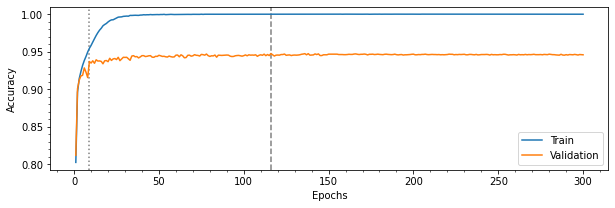

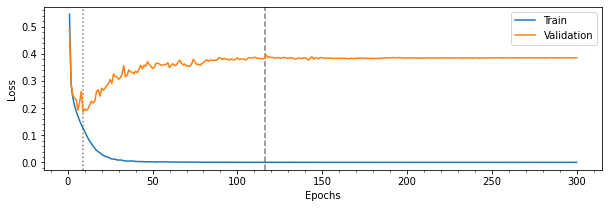

In [3]:
data = pd.read_csv('tmp/WRN28_10.csv')
max_val_acc_epoch = np.argmax(list(data['val_accuracy']))+1
max_val_loss_epoch = np.argmin(list(data['val_loss']))+1
epochs = range(1, len(data['accuracy']) + 1)
plt.figure(figsize=(10,3))
plt.minorticks_on()
plt.axvline(x=max_val_acc_epoch, color='0.5', linestyle='--')
plt.axvline(x=max_val_loss_epoch, color='0.5', linestyle=':')
plt.plot(epochs,data['accuracy'], label='Train')
plt.plot(epochs,data['val_accuracy'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10,3))
plt.minorticks_on()
plt.axvline(x=max_val_acc_epoch, color='0.5', linestyle='--')
plt.axvline(x=max_val_loss_epoch, color='0.5', linestyle=':')
plt.plot(epochs,data['loss'], label='Train')
plt.plot(epochs,data['val_loss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


* Best accuracy model picked at around epoch 120
* Loss at around epoch 10
* Still overfitting
* Slight improvement over baseline model on performance

<h4>Data Augmented WRN28-10</h4>

In [6]:
def scheduler(epoch,lr):
    if epoch <150:
        lr = 0.1
        print('Learning rate:',lr)
        return lr
    elif epoch < 225:
        lr = 0.01
        print('Learning rate:',lr)
        return lr
    else:
        lr = 0.001
        print('Learning rate:',lr)
        return lr


params = {'depth': 28,
          'width': 10,
          'drop_prob': 0.3,
          'num_classes': 10}
image_train_new = np.expand_dims(image_train, -1)
x = tf.keras.Input((28,28,1))
out = WRN(x,params)
model_AUG = keras.models.Model(inputs=x,outputs = out)
top3 = tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3,name='top_3_accuracy')
opt = tf.keras.optimizers.SGD(momentum=0.9,decay=0.0005,nesterov=True,learning_rate=0.1)
log_28_10_Aug = CSVLogger('tmp/WRN28_10_Aug.csv',separator = ',',append=True)
checkpoint = tf.keras.callbacks.ModelCheckpoint('tmp/checkpoint/WRN_28-10_AUG.hdf5',verbose=True)
getAcc = tf.keras.callbacks.ModelCheckpoint('tmp/checkpoint/WRN_28-10_AUG_Acc.hdf5',verbose=True,save_best_only=True,monitor='val_accuracy')
getLoss = tf.keras.callbacks.ModelCheckpoint('tmp/checkpoint/WRN_28-10_AUG_Loss.hdf5',verbose=True,save_best_only=True,monitor='val_loss')
scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
model_AUG.compile(optimizer=opt,loss='sparse_categorical_crossentropy',metrics=['accuracy',top3])
gen = ImageDataGenerator(height_shift_range=1,width_shift_range=1,horizontal_flip=True,preprocessing_function=lambda x : RandomErasing(x,0.5,0.02,0.4,0.3))

In [ ]:
history_AUG = model_AUG.fit(gen.flow(image_train_new,labels_train,batch_size = 128),validation_data=(image_val,labels_val),epochs=300,callbacks=[checkpoint,scheduler,getAcc,getLoss,log_28_10_Aug])

In [7]:
model_AUG.load_weights('tmp/checkpoint/WRN_28-10_AUG_Acc.hdf5')
scoreAcc = model_AUG.evaluate(image_test,labels_test)
model_AUG.load_weights('tmp/checkpoint/WRN_28-10_AUG_Loss.hdf5')
scoreLoss = model_AUG.evaluate(image_test,labels_test)
print('Best Acc Test Loss:', scoreAcc[0])
print('Best Acc Test Accuracy:', round(scoreAcc[1],4)*100,'%')
print('Best Loss Test Loss:', scoreLoss[0])
print('Best Loss Test Accuracy:', round(scoreLoss[1],4)*100,'%')

313/313 [==============================] - 11s 35ms/step - loss: 0.1821 - accuracy: 0.9436 - top_3_accuracy: 0.9957
Best Acc Test Loss: 0.2705497145652771
Best Acc Test Accuracy: 95.12 %
Best Loss Test Loss: 0.18206731975078583
Best Loss Test Accuracy: 94.36 %


* Data augmentation has improved the best test accuracy by 1.08%
* Improved best loss by about 0.0276
* Overall improvement of loss for both best accuracy and loss weights

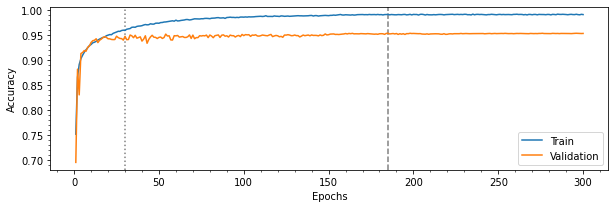

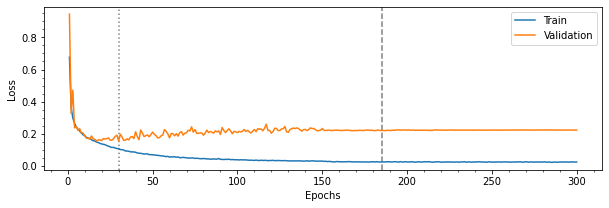

In [15]:
data_AUG = pd.read_csv('tmp/WRN28_10_Aug.csv')
max_val_acc_epoch = np.argmax(list(data_AUG['val_accuracy']))+1
max_val_loss_epoch = np.argmin(list(data_AUG['val_loss']))+1
epochs = range(1, len(data_AUG['accuracy']) + 1)
plt.figure(figsize=(10,3))
plt.minorticks_on()
plt.axvline(x=max_val_acc_epoch, color='0.5', linestyle='--')
plt.axvline(x=max_val_loss_epoch, color='0.5', linestyle=':')
plt.plot(epochs,data_AUG['accuracy'], label='Train')
plt.plot(epochs,data_AUG['val_accuracy'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10,3))
plt.minorticks_on()
plt.axvline(x=max_val_acc_epoch, color='0.5', linestyle='--')
plt.axvline(x=max_val_loss_epoch, color='0.5', linestyle=':')
plt.plot(epochs,data_AUG['loss'], label='Train')
plt.plot(epochs,data_AUG['val_loss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

* Improvement in overfitting
* Validation is closer training for both best acc and loss
* Generalization improved
* Still some overfitting observed

<h5>Data Aug with label smoothing</h5>

* Wrote WRN 28-10 model with data augmentation and introduced label smoothing

In [11]:
def scheduler(epoch,lr):
    if epoch <150:
        lr = 0.1
        print('Learning rate:',lr)
        return lr
    elif epoch < 225:
        lr = 0.01
        print('Learning rate:',lr)
        return lr
    else:
        lr = 0.001
        print('Learning rate:',lr)
        return lr

image_train_new = np.expand_dims(image_train, -1)
params = {'depth': 28,
          'width': 10,
          'drop_prob': 0.3,
          'num_classes': 10}

x = tf.keras.Input((28,28,1))
out = WRN(x,params)
model_AUG_smooth = keras.models.Model(inputs=x,outputs = out)
top3 = tf.keras.metrics.TopKCategoricalAccuracy(k=3,name='top_3_accuracy')
opt = tf.keras.optimizers.SGD(momentum=0.9,decay=0.0005,nesterov=True,learning_rate=0.1)
log_28_10_Aug = CSVLogger('tmp/WRN28_10_AugSmooth.csv',separator = ',',append=True)
checkpoint = tf.keras.callbacks.ModelCheckpoint('tmp/checkpoint/WRN_28-10_AUGSmooth.hdf5',verbose=True)
getAcc = tf.keras.callbacks.ModelCheckpoint('tmp/checkpoint/WRN_28-10_AUG_AccSmooth.hdf5',verbose=True,save_best_only=True,monitor='val_accuracy')
getLoss = tf.keras.callbacks.ModelCheckpoint('tmp/checkpoint/WRN_28-10_AUG_LossSmooth.hdf5',verbose=True,save_best_only=True,monitor='val_loss')
scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
model_AUG_smooth.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy',top3])
gen = ImageDataGenerator(height_shift_range=1,width_shift_range=1,horizontal_flip=True,preprocessing_function=lambda x : RandomErasing(x,0.5,0.02,0.4,0.3))

In [ ]:
history_AUG_Smooth = model_AUG_smooth.fit(gen.flow(image_train_new,labels_train_oh,batch_size = 128),validation_data = (image_val,labels_val_oh),epochs=300,callbacks=[checkpoint,scheduler,getAcc,getLoss,log_28_10_Aug])

In [13]:
model_AUG_smooth.load_weights('tmp/checkpoint/WRN_28-10_AUG_AccSmooth.hdf5')
scoreAcc = model_AUG_smooth.evaluate(image_test,labels_test_oh)
model_AUG_smooth.load_weights('tmp/checkpoint/WRN_28-10_AUG_LossSmooth.hdf5')
scoreLoss = model_AUG_smooth.evaluate(image_test,labels_test_oh)
print('Best Acc Test Loss:', scoreAcc[0])
print('Best Acc Test Accuracy:', round(scoreAcc[1],4)*100,'%')
print('Best Loss Test Loss:', scoreLoss[0])
print('Best Loss Test Accuracy:', round(scoreLoss[1],4)*100,'%')

313/313 [==============================] - 11s 34ms/step - loss: 0.1776 - accuracy: 0.9424 - top_3_accuracy: 0.9963
Best Acc Test Loss: 0.23648801445960999
Best Acc Test Accuracy: 94.86 %
Best Loss Test Loss: 0.1776430308818817
Best Loss Test Accuracy: 94.24 %


* Label smoothing did not improve best test accuracy, but improved best test loss by ~0.01

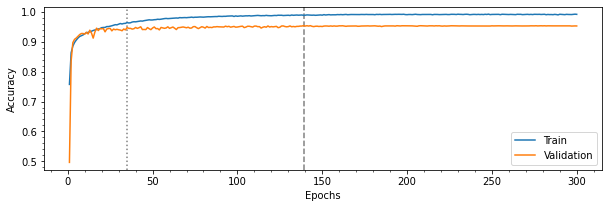

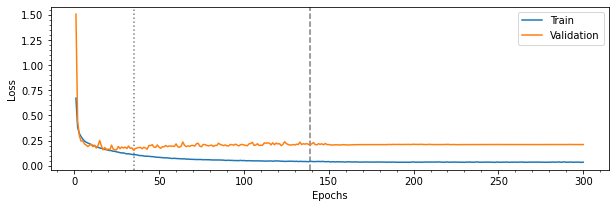

In [14]:
data_AUG = pd.read_csv('tmp/WRN28_10_AugSmooth.csv')
max_val_acc_epoch = np.argmax(list(data_AUG['val_accuracy']))+1
max_val_loss_epoch = np.argmin(list(data_AUG['val_loss']))+1
epochs = range(1, len(data_AUG['accuracy']) + 1)
plt.figure(figsize=(10,3))
plt.minorticks_on()
plt.axvline(x=max_val_acc_epoch, color='0.5', linestyle='--')
plt.axvline(x=max_val_loss_epoch, color='0.5', linestyle=':')
plt.plot(epochs,data_AUG['accuracy'], label='Train')
plt.plot(epochs,data_AUG['val_accuracy'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10,3))
plt.minorticks_on()
plt.axvline(x=max_val_acc_epoch, color='0.5', linestyle='--')
plt.axvline(x=max_val_loss_epoch, color='0.5', linestyle=':')
plt.plot(epochs,data_AUG['loss'], label='Train')
plt.plot(epochs,data_AUG['val_loss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

<h3><b>Conclusions/Discussions</b></h3>

<p>In this classification task, we have succeeded in creating a pipeline/model that can achieve ~95% test accuracy, a top 3 test accuracy of ~99% and a test loss of ~0.27, achieving our ultimate goal of getting accuracy near or above 95%. We also have models that do not have as high a test accuracy, but have the best loss out of all them, with ~94% test accuracy, a top 3 test accuracy of ~99% and a test loss of ~0.18.</p>

<p>However, that's not to say that our baseline did poorly. In fact, it performed remarkably well, this may be due to the simplicity of the chosen dataset, which are 28x28, 1 channel images, making even simple CNNs perform well as the images passed through are not very complicated.</p>

<p>Even with a more complex CNN following WideResNet architecture, we only saw slight increases in performance. </p>

<p>This suggests to us that the improvement of performance gets more diminished as performace reaches very high percentages. Where even a model as complex as WRN 28-10, with ~36M params can only provide a small increase in accuracy of ~1% compared to simple baseline.</p>

<p>In tasks such as this one, the important thing to focus on is not simply model complexity, as that seems to provide us diminishing returns. Instead focus more on regularization methods, like ones implemented in this notebook, such as label smoothing, dropout, random erasing, random cropping/flipping and to some extent, batch normalization. Regularization methods like these if carefully used can improve our performance without drastically increasing computational cost.</p>

<p>In doing so, we have also achieved our secondary objective of using our best model and reducing overfitting on it.</p>

<p>For the more complex WRN 28-10, which may overfit more, the regularization methods have helped it reduce overfitting and improve performance.</p>

<p>Overall, our objective has been completed. From this notebook, we have seen that model complexity can improve overall accuracy and loss of our models at the cost of computational cost, however this may incur overfitting. But overfitting can be mitigated with the help of regularization methods, helping to improve our model's overall preformance without too much additional computational cost. In terms of computational cost, judgment must be exercised to ensure that the model used fits the needs and desires of the task.</p>